In [17]:

# ### Will perform the practice on the same data before modular coding to be done.
#
#
# Hope it goes well :)

In [18]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [19]:
# %%
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain


In [20]:
from sklearn.metrics import mean_absolute_error, r2_score

In [21]:
from sklearn.tree import export_graphviz
from sklearn import tree


In [22]:
df = pd.read_csv('open-meteo-18.62N74.00E561m.csv')

In [23]:
df.shape

(131184, 10)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131184 entries, 0 to 131183
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   location_id               131184 non-null  int64  
 1   time                      131184 non-null  object 
 2   temperature_2m (°C)       131184 non-null  float64
 3   relative_humidity_2m (%)  131184 non-null  int64  
 4   dew_point_2m (°C)         131184 non-null  float64
 5   rain (mm)                 131184 non-null  float64
 6   pressure_msl (hPa)        131184 non-null  float64
 7   surface_pressure (hPa)    131184 non-null  float64
 8   cloud_cover (%)           131184 non-null  int64  
 9   wind_speed_10m (km/h)     131184 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 10.0+ MB


In [25]:
df.columns


Index(['location_id', 'time', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'rain (mm)',
       'pressure_msl (hPa)', 'surface_pressure (hPa)', 'cloud_cover (%)',
       'wind_speed_10m (km/h)'],
      dtype='object')

In [26]:
# Rename for convenience
df.rename(columns={
    'temperature_2m (°C)': 'temperature',
    'relative_humidity_2m (%)': 'humidity',
    'dew_point_2m (°C)': 'dew_point',
    'rain (mm)': 'rain',
    'pressure_msl (hPa)': 'pressure_msl',
    'surface_pressure (hPa)': 'surface_pressure',
    'cloud_cover (%)': 'cloud_cover',
    'wind_speed_10m (km/h)': 'wind_speed',
    'time': 'datetime'
}, inplace=True)


In [27]:
# Convert datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

In [28]:
# %%
df['hour'] = df['datetime'].dt.hour

In [29]:
# %%
df = df.sort_values(['location_id', 'datetime'])

In [30]:
df.head()

,location_id,datetime,temperature,humidity,dew_point,rain,pressure_msl,surface_pressure,cloud_cover,wind_speed,date,hour
0,0,2023-01-01 00:00:00,13.7,91,12.2,0.0,1017.3,951.9,0,2.8,2023-01-01,0
1,0,2023-01-01 01:00:00,13.4,92,12.1,0.0,1018.0,952.5,0,3.1,2023-01-01,1
2,0,2023-01-01 02:00:00,13.2,92,12.0,0.0,1019.1,953.5,0,3.1,2023-01-01,2
3,0,2023-01-01 03:00:00,15.9,81,12.7,0.0,1019.5,954.5,0,2.1,2023-01-01,3
4,0,2023-01-01 04:00:00,19.7,66,13.2,0.0,1020.4,956.2,0,1.8,2023-01-01,4


In [31]:
# %%
for lag_day in range(1, 6):  # 1 to 5 days back
    lag_hours = lag_day * 24
    df[f'temp_lag_{lag_day}d'] = df.groupby('location_id')['temperature'].shift(lag_hours)

In [32]:
# Create target columns for next 24 hours
for hour_ahead in range(1, 25):  # 1 to 24 hours ahead
    df[f'temp_t+{hour_ahead}'] = df.groupby('location_id')['temperature'].shift(-hour_ahead)


In [33]:
# %%
df = df.dropna()


In [34]:
# %%
df.isnull().sum().sum()

np.int64(0)

In [35]:
df.head()


,location_id,datetime,temperature,humidity,dew_point,rain,pressure_msl,surface_pressure,cloud_cover,wind_speed,...,temp_t+15,temp_t+16,temp_t+17,temp_t+18,temp_t+19,temp_t+20,temp_t+21,temp_t+22,temp_t+23,temp_t+24
120,0,2023-01-06 00:00:00,18.7,89,16.9,0.0,1017.4,953.1,70,2.2,...,22.7,21.9,21.2,21.0,20.8,20.6,20.5,20.3,20.1,19.9
121,0,2023-01-06 01:00:00,18.6,90,17.0,0.0,1018.5,954.1,77,2.5,...,21.9,21.2,21.0,20.8,20.6,20.5,20.3,20.1,19.9,19.8
122,0,2023-01-06 02:00:00,18.5,92,17.1,0.0,1019.4,954.9,61,2.9,...,21.2,21.0,20.8,20.6,20.5,20.3,20.1,19.9,19.8,19.7
123,0,2023-01-06 03:00:00,20.1,85,17.5,0.0,1020.1,955.9,46,4.0,...,21.0,20.8,20.6,20.5,20.3,20.1,19.9,19.8,19.7,20.5
124,0,2023-01-06 04:00:00,22.1,75,17.5,0.0,1020.7,956.9,61,12.0,...,20.8,20.6,20.5,20.3,20.1,19.9,19.8,19.7,20.5,21.8


In [36]:
#
df_sample = df.tail(50000)

In [37]:
# %%
input_features = [
    'temperature', 'humidity', 'dew_point', 'rain', 'pressure_msl',
    'surface_pressure', 'cloud_cover', 'wind_speed',
    'temp_lag_1d', 'temp_lag_2d', 'temp_lag_3d', 'temp_lag_4d', 'temp_lag_5d'
]
# Fix: use fewer outputs initially
target_features = [f'temp_t+{i}' for i in range(1, 25)]  # 24 hours ahead

In [38]:
# %%
x = df[input_features]
y = df[target_features]

In [39]:

# Check nulls
print(x.isnull().sum().sum())
print(y.isnull().sum().sum())

0
0


In [40]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

In [41]:
base_model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
# Multi-output wrapper
model = MultiOutputRegressor(base_model)
# Fit
model.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=50, n_jobs=-1,
                                                     random_state=42))

In [42]:
# Predict
y_pred = model.predict(x_test)

In [44]:
from sklearn.metrics import mean_squared_error

In [45]:
# Initialize lists to store results
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for i in range(y.shape[1]):
    y_true = y_test.iloc[:, i]
    y_hat = y_pred[:, i]

    mse = mean_squared_error(y_true, y_hat)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_hat)
    r2 = r2_score(y_true, y_hat)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"Horizon temp_t+{i+1}:")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R2  : {r2:.2f}")
    print("-" * 30)


Horizon temp_t+1:
  MSE : 1.16
  RMSE: 1.08
  MAE : 0.74
  R2  : 0.96
------------------------------
Horizon temp_t+2:
  MSE : 3.79
  RMSE: 1.95
  MAE : 1.36
  R2  : 0.86
------------------------------
Horizon temp_t+3:
  MSE : 6.99
  RMSE: 2.64
  MAE : 1.88
  R2  : 0.74
------------------------------
Horizon temp_t+4:
  MSE : 10.14
  RMSE: 3.18
  MAE : 2.28
  R2  : 0.62
------------------------------
Horizon temp_t+5:
  MSE : 12.61
  RMSE: 3.55
  MAE : 2.54
  R2  : 0.53
------------------------------
Horizon temp_t+6:
  MSE : 13.98
  RMSE: 3.74
  MAE : 2.66
  R2  : 0.48
------------------------------
Horizon temp_t+7:
  MSE : 14.25
  RMSE: 3.78
  MAE : 2.66
  R2  : 0.47
------------------------------
Horizon temp_t+8:
  MSE : 13.44
  RMSE: 3.67
  MAE : 2.56
  R2  : 0.50
------------------------------
Horizon temp_t+9:
  MSE : 12.26
  RMSE: 3.50
  MAE : 2.42
  R2  : 0.55
------------------------------
Horizon temp_t+10:
  MSE : 10.88
  RMSE: 3.30
  MAE : 2.27
  R2  : 0.60
-------------

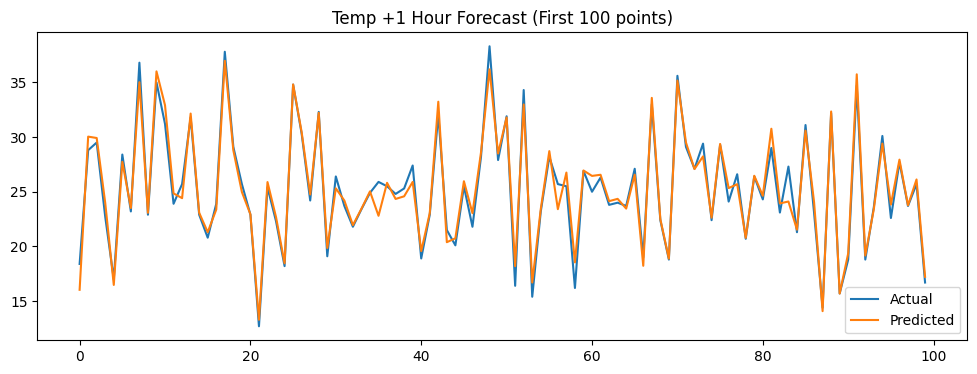

In [46]:
# Plot example (first output horizon)
plt.figure(figsize=(12, 4))
plt.plot(np.array(y_test.iloc[:, 0].values[:100]), label='Actual')
plt.plot(y_pred[:100, 0], label='Predicted')
plt.legend()
plt.title('Temp +1 Hour Forecast (First 100 points)')
plt.show()

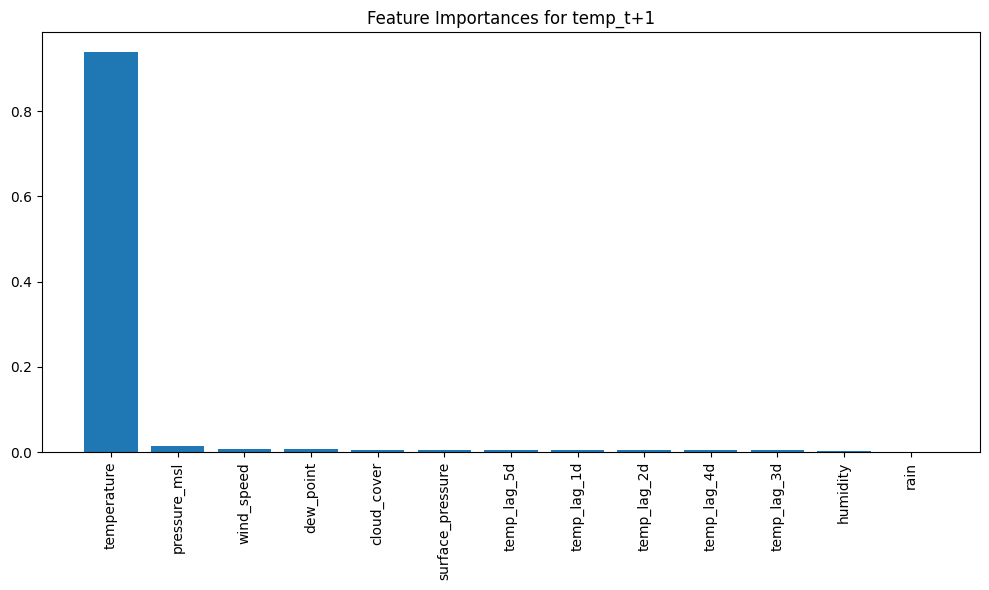

In [47]:
# Pick, say, first horizon (temp_t+1)
first_rf = model.estimators_[0]

importances = first_rf.feature_importances_
feature_names = x_train.columns

# Sort
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for temp_t+1")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

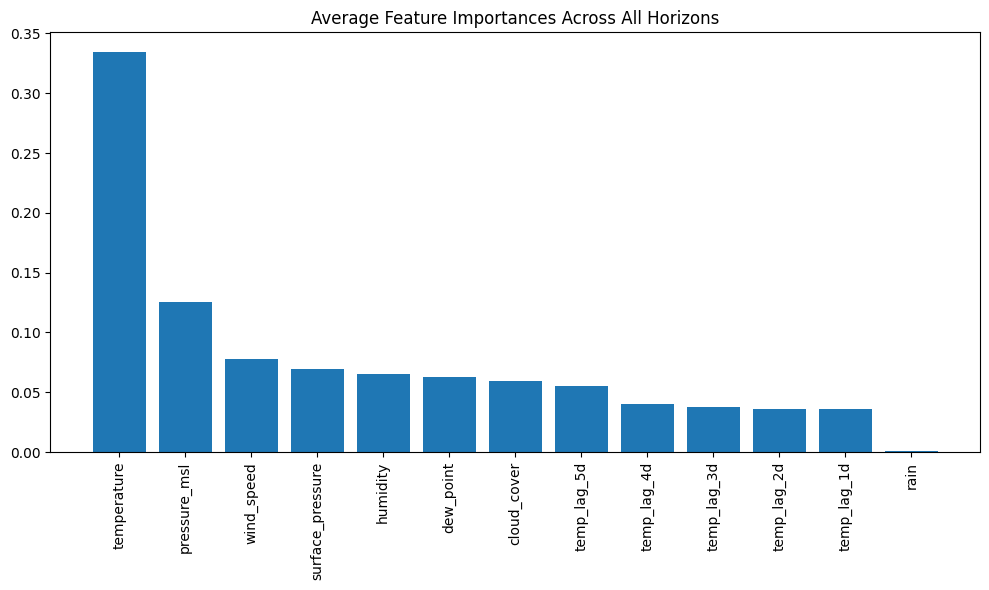

In [48]:
# Collect all importances
importances_all = np.array([est.feature_importances_ for est in model.estimators_])

# Average
avg_importances = np.mean(importances_all, axis=0)

# Create DataFrame
imp_df = pd.DataFrame({'feature': feature_names, 'importance': avg_importances})
imp_df = imp_df.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.title("Average Feature Importances Across All Horizons")
plt.bar(imp_df['feature'], imp_df['importance'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

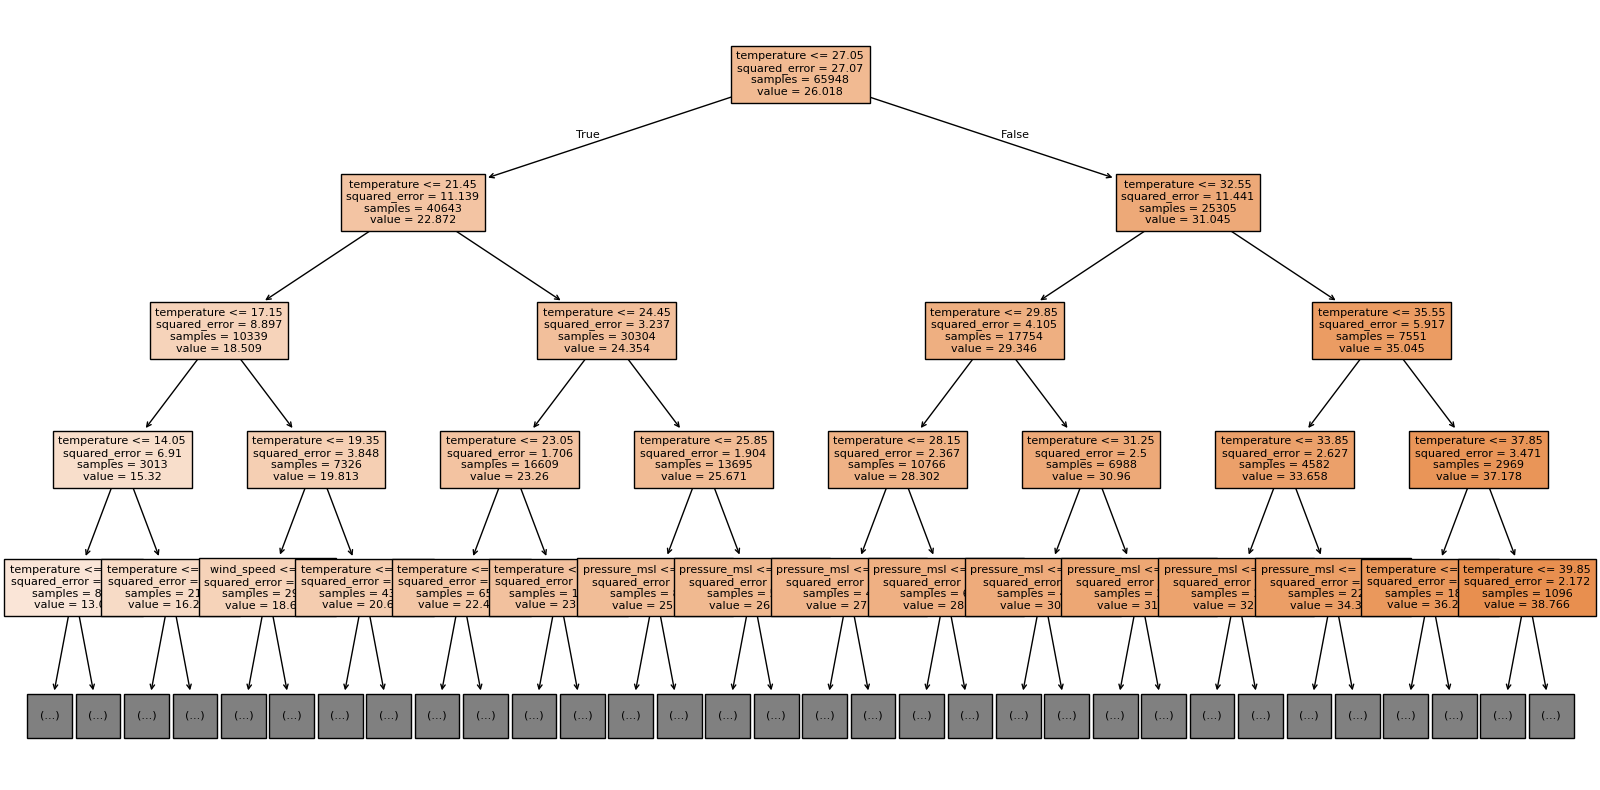

In [49]:
estimator = model.estimators_[0].estimators_[0]  # First tree of first RF regressor

plt.figure(figsize=(20, 10))
tree.plot_tree(estimator,
               feature_names=feature_names,
               filled=True,
               max_depth=4,  # You can increase this if needed, but keep it small first
               fontsize=8)
plt.show()


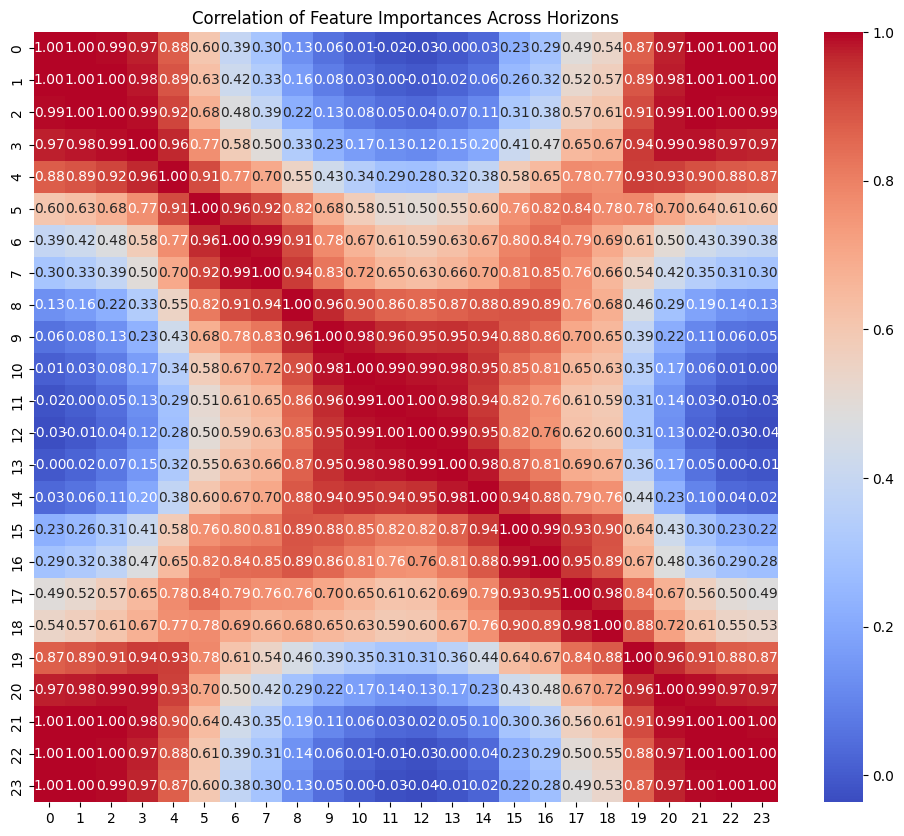

In [50]:
importances_all_df = pd.DataFrame(importances_all, columns=feature_names)

# Correlation matrix
corr_matrix = importances_all_df.T.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation of Feature Importances Across Horizons")
plt.show()

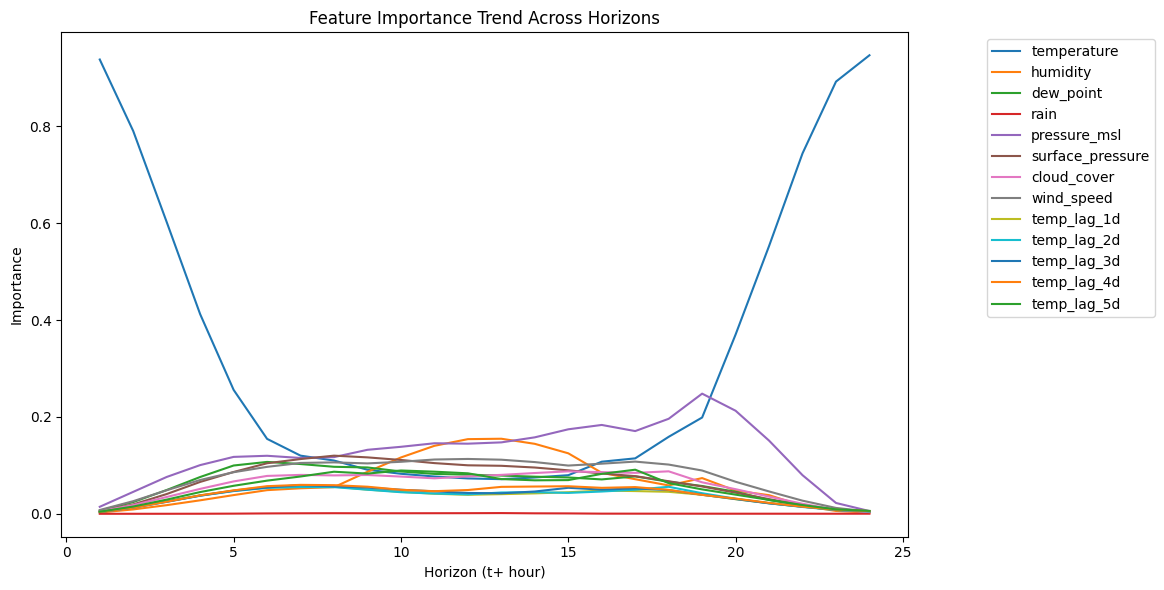

In [51]:
plt.figure(figsize=(12, 6))
for i, feat in enumerate(feature_names):
    plt.plot(range(1, importances_all.shape[0] + 1), importances_all[:, i], label=feat)
plt.xlabel('Horizon (t+ hour)')
plt.ylabel('Importance')
plt.title('Feature Importance Trend Across Horizons')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

In [52]:
del model
del base_model
del x_train, x_test, y_train, y_test

In [53]:
import gc
gc.collect()

54006